In [2]:
import mxnet as mx
import keras  
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import numpy

Using TensorFlow backend.


In [3]:
vocabsize = 20000

(X_train, y_train), (X_test, y_test)  = imdb.load_data(nb_words=vocabsize)

# We need to pad the training data with 0's, so they all have lenghth of 500. As mojority of review fall into 500 words or less
X_train = pad_sequences(X_train, maxlen=500)
X_test = pad_sequences(X_test, maxlen=500)

# Create MXNet NDArray Iterator from the numpy training set and labels
# in order to assign numpy array to MXNet NDArrayIter, the input vector needs to be same size and padded if it is short
# 128 is the batch size.  We can choose to shuffle the data (true or false)
Batch_Size = 256

trainIter = mx.io.NDArrayIter(X_train, y_train, Batch_Size, shuffle=True)
testIter = mx.io.NDArrayIter(X_test, y_test, Batch_Size, shuffle=True)

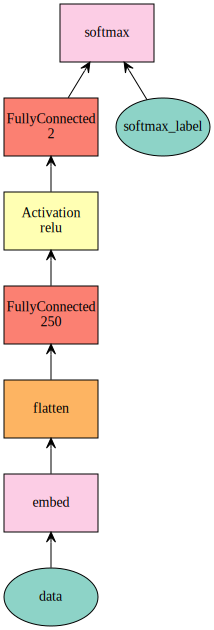

In [4]:
# create MLP network using MXNet
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

inputdata = mx.sym.Variable('data')
input_y = mx.sym.Variable('softmax_label')  # placeholder for output

# input_dim is the size of the vocaburary.  output_dim is the dimension of the output embedded vector.
Embeddata = mx.sym.Embedding(data = inputdata, input_dim=vocabsize, output_dim=32, name='embed') 

data1 = mx.sym.Flatten(data = Embeddata, name='flatten')

fc1  = mx.sym.FullyConnected(data=data1, num_hidden=250) 
act1 = mx.sym.Activation(data=fc1, act_type="relu")  #tanh or relu

#dropout = mx.sym.Dropout(data=act1, p=0.1)

fc2 = mx.sym.FullyConnected(data=act1, num_hidden=2) 
mlp = mx.sym.SoftmaxOutput(data=fc2, label=input_y, name='softmax')

mx.viz.plot_network(mlp)


In [5]:


# Train the model
num_epoch = 20

def norm_stat(d):
    """The statistics you want to see.
    We compute the L2 norm here but you can change it to anything you like."""
    return mx.nd.norm(d)/numpy.sqrt(d.size)


mlp_model = mx.mod.Module(symbol=mlp, context=mx.gpu()) 

mon = mx.mon.Monitor(
    100,                 # Print every 100 batches
    norm_stat,           # The statistics function defined above
    pattern='.*weight',  # A regular expression. Only arrays with name matching this pattern will be included.
    sort=True)           # Sort output by name

mlp_model.fit(trainIter,  # training data               
    eval_data=testIter,  # validation data                            
    optimizer="adam",  # use adam to train
    optimizer_params={'learning_rate':0.01}, # set learning rate for adam         
    eval_metric='acc',  # report accuracy during training  
    batch_end_callback = mx.callback.Speedometer(Batch_Size, 100), # output progress for each 100 data batches   
    num_epoch=num_epoch, # train at most 10 data passes
    monitor=mon
    )  


INFO:root:Batch:       1 embed_weight                   0.00720465	
INFO:root:Batch:       1 fullyconnected0_backward_weight 1.0408e-06	
INFO:root:Batch:       1 fullyconnected0_weight         0.0080166	
INFO:root:Batch:       1 fullyconnected1_backward_weight 7.03324e-05	
INFO:root:Batch:       1 fullyconnected1_weight         0.0119504	
INFO:root:Epoch[0] Train-accuracy=0.764908
INFO:root:Epoch[0] Time cost=2.604
INFO:root:Epoch[0] Validation-accuracy=0.858538
INFO:root:Batch:     101 embed_weight                   0.107894	
INFO:root:Batch:     101 fullyconnected0_backward_weight 2.07295e-05	
INFO:root:Batch:     101 fullyconnected0_weight         0.0675628	
INFO:root:Batch:     101 fullyconnected1_backward_weight 0.0371466	
INFO:root:Batch:     101 fullyconnected1_weight         0.0210811	
INFO:root:Epoch[1] Train-accuracy=0.941327
INFO:root:Epoch[1] Time cost=2.262
INFO:root:Epoch[1] Validation-accuracy=0.871452
INFO:root:Batch:     201 embed_weight                   0.145561	
INF

INFO:root:Epoch[17] Train-accuracy=1.000000
INFO:root:Epoch[17] Time cost=2.281
INFO:root:Epoch[17] Validation-accuracy=0.856545
INFO:root:Batch:    1801 embed_weight                   0.321834	
INFO:root:Batch:    1801 fullyconnected0_backward_weight 1.13178e-08	
INFO:root:Batch:    1801 fullyconnected0_weight         0.260914	
INFO:root:Batch:    1801 fullyconnected1_backward_weight 1.05084e-05	
INFO:root:Batch:    1801 fullyconnected1_weight         0.0675808	
INFO:root:Epoch[18] Train-accuracy=1.000000
INFO:root:Epoch[18] Time cost=2.275
INFO:root:Epoch[18] Validation-accuracy=0.856425
INFO:root:Batch:    1901 embed_weight                   0.321843	
INFO:root:Batch:    1901 fullyconnected0_backward_weight 2.21926e-06	
INFO:root:Batch:    1901 fullyconnected0_weight         0.260915	
INFO:root:Batch:    1901 fullyconnected1_backward_weight 0.0011728	
INFO:root:Batch:    1901 fullyconnected1_weight         0.0676053	
INFO:root:Epoch[19] Train-accuracy=1.000000
INFO:root:Epoch[19] Ti

In [7]:
# Save the model
prefix = "sentiment_mlp_"
mlp_model.save_checkpoint (prefix, num_epoch)

INFO:root:Saved checkpoint to "sentiment_mlp_-0010.params"
